#ALTEGRAD KAGGLE PROJECT
CECCINI Alessandro \\
CHAUVIN Paul \\
LOISEAU Thibaut \\

#Part 1: Sequence-based models 
In this notebook, we explored several paths for protein classification. We use sequence-based models.
- Modifying the baseline with Decision Tree and Support Vector Machine
- Prot Computational Neural Network
- Bidirectional Long Short Term Memory
- Standard Recurrent Neural Network


#Environment

In [1]:
!pip install transformers
!pip install simpletransformers
!pip install keras
!pip install keras.preprocessing.sequence
!pip install plot_keras_history
!pip install keras.utils
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.5/250.5 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
%matplotlib inline
import os
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image
import csv
import numpy as np
import time
import statistics
import math
from tqdm import tqdm
import pickle
import scipy.sparse as sp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

from simpletransformers.classification import MultiLabelClassificationModel
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import scipy.sparse as sp
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForMaskedLM

import keras
import keras.preprocessing.sequence
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, CuDNNLSTM, GlobalMaxPooling1D, LSTM
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
use_cuda_bool = True if torch.cuda.is_available() else False

#Data Exploration

###Data loading

In [4]:
path_to_data = '/content/drive/MyDrive/Cours_MVA/1er semestre/ALTEGRAD/Kaggle_project/altegrad_challenge_2022/'

In [5]:
colnames1=['sequence'] 
df1 = pd.read_csv(path_to_data + 'sequences.txt', names=colnames1, header=None)
df1['sequence_length'] = df1['sequence'].str.len()
colnames1=['sequence'] 
df = pd.read_csv(path_to_data + 'sequences.txt', names=colnames1, header=None)
df.head()
colnames2=['id', 'location'] 
df = pd.read_csv(path_to_data + 'graph_labels.txt', names=colnames2, header=None)
df['is_train'] = df['location']
mask = pd.notna(df['is_train'])
df['is_train'][mask] = 1
df['is_train'].fillna(0, inplace=True)

data = pd.concat([df1, df], axis=1)

data.head()

<ipython-input-5-868f76f7b136>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_train'][mask] = 1


,sequence,sequence_length,id,location,is_train
0,AYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLS...,327,11as,NaN,0.0
1,RTDCYGNVNRIDTTGASCKTAKPEGLSYCGVSASKKIAERDLQAMD...,185,154l,8.0,1.0
2,EKKSINECDLKGKKVLIRVDFNVPVKNGKITNDYRIRSALPTLKKV...,415,16pk,NaN,0.0
3,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLAAAKAAL...,162,192l,4.0,1.0
4,AALEPTDSGAPSAIVMFPVGEKPNPKGAAMKPVVFNHLIHEKKIAD...,292,19hc,NaN,0.0


In [6]:
# filter data by is_train=1
df_train_eval = data.loc[data['is_train'] == 1]
df_test = data.loc[data['is_train'] == 0]

### Down sampling

In [ ]:
# Downsampling the data


# Number of rows per class
n = 50

# Shuffle the DataFrame
df_train_eval = shuffle(df_train_eval)

# Group the DataFrame by the 'location' column
groups = df_train_eval.groupby('location')

# Initialize an empty DataFrame for the train set
df_train = pd.DataFrame()

# Initialize an empty DataFrame for the eval set
df_eval = pd.DataFrame()

# Iterate over the groups
for name, group in groups:
    # Select the first n rows from the group
    group_train = group.iloc[:n]
    # Select the remaining rows from the group
    group_eval = group.iloc[n:]
    # Append the rows to the train DataFrame
    df_train = pd.concat([df_train, group_train], ignore_index=True)
    # Append the rows to the eval DataFrame
    df_eval = pd.concat([df_eval, group_eval], ignore_index=True)



### Up sampling

In [ ]:
import pandas as pd

# Assuming your data is stored in a dataframe called 'df'
location_counts = df_train_eval.groupby('location').size()

print(location_counts)
df_train_eval.shape


for label in range(18):
  if df_train_eval['location']==label:
    

location
0.0     440
1.0      50
2.0     939
3.0      60
4.0     112
5.0     625
6.0     202
7.0      74
8.0     998
9.0      57
10.0     43
11.0    305
12.0     44
13.0     59
14.0    548
15.0    226
16.0     60
17.0     46
dtype: int64


(4888, 5)

In [ ]:
# Count the number of rows for each class
class_counts = df_train_eval['location'].value_counts()

# Find the class with the minimum number of rows
max_class = class_counts.max()

# Create a new dataframe to store the upsampled data
upsampled_df = pd.DataFrame()

# Iterate over each class
for class_value in range(18):
    # Select rows for the current class
    class_rows = df_train_eval[df_train_eval['location'] == class_value]
    # Upsample the class to have the same number of rows as the minimum class
    upsampled_class = resample(class_rows,
                              replace=True,
                              n_samples=max_class,
                              random_state=123)
    # Append the upsampled class to the new dataframe
    upsampled_df = upsampled_df.append(upsampled_class)

# Shuffle the rows of the new dataframe
df_train_eval = upsampled_df.sample(frac=1)


# split train_eval dataframe into train and eval
df_train, df_eval = train_test_split(df_train_eval, test_size=0.2, random_state=42)
print(df_train_eval.shape)
print(df_train.shape)
print(df_eval.shape)


(17964, 5)
(14371, 5)
(3593, 5)


### No up/downsampling

In [7]:
# classic dataset : no up nor downsampling
# split train_eval dataframe into train and eval
df_train, df_eval = train_test_split(df_train_eval, test_size=0.2, random_state=42)


### Data Visualization

In [ ]:
print(df_train.shape)
df_train.head()

(3910, 5)


,sequence,sequence_length,id,location,is_train
5008,DANTFFGAESVQDPYPLYERMRAAGSVHRIANSDFYAVCGWDAVNE...,397,5hdi,14.0,1.0
3258,VANTRIYAAEKLAKVKEKADSPLYAPAVKTLLRDADKALKTPPSVD...,363,3nnb,6.0,1.0
3870,DTLCIGYHANNSTDTVDTVLEKNVTVTHSVNLLEDKHNGKLCKLRG...,321,4eda,0.0,1.0
4981,MLKSVTVSAPSNIAVVKYWGKRGDERLNLPLNNSLSITLDDQLSVI...,325,5gmd,2.0,1.0
5069,QPFLKRGEGLARF,13,5itz,11.0,1.0


In [ ]:
print(df_eval.shape)
df_eval.head()

(978, 5)


,sequence,sequence_length,id,location,is_train
164,GTLDTTWKEATLPQVKAMLEKDTGKVSGDTVTYSGKTVHVVAAAVL...,155,1cur,6.0,1.0
89,LPQSFLLKCLEQMRKVQADGTALQETLCATHQLCHPEELVLLGHAL...,157,1bgd,8.0,1.0
2633,EPLYSLRPEHARERLQDDSVETVTSIEQAKVEEKIQEVFSSYKFNH...,402,2zir,15.0,1.0
5927,RRTLWTTPDTSPNCKMSTEKDSKLTLTLTKCGSQVLGNVSLLAVTG...,184,6fjp,0.0,1.0
3576,VTAFLGERVTLTSYWRRVSLGPEIEVSWFKLGPGEEQVLIGRMHHD...,185,3uez,8.0,1.0


In [ ]:
print(df_test.shape)
df_test.head()

(1223, 5)


,sequence,sequence_length,id,location,is_train
0,AYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLS...,327,11as,NaN,0.0
2,EKKSINECDLKGKKVLIRVDFNVPVKNGKITNDYRIRSALPTLKKV...,415,16pk,NaN,0.0
4,AALEPTDSGAPSAIVMFPVGEKPNPKGAAMKPVVFNHLIHEKKIAD...,292,19hc,NaN,0.0
27,AITGIFFGSDTGNTENIAKMIQKQLGKDVADVHDIAKSSKEDLEAY...,175,1ag9,NaN,0.0
28,KNNVVIVATGGTIAGAGASSTNSATYSAAKVPVDALIKAVPQVNDL...,331,1agx,NaN,0.0


In [ ]:
class_counts = df_train['location'].value_counts()

# to print the results
print(class_counts)

8.0     804
2.0     749
5.0     496
14.0    437
0.0     352
11.0    240
15.0    186
6.0     156
4.0      87
7.0      61
16.0     52
9.0      49
3.0      48
13.0     45
12.0     39
1.0      37
17.0     37
10.0     35
Name: location, dtype: int64


In [ ]:
grouped_df = df_train.groupby('location').mean()
sequence_length_avg = grouped_df['sequence_length']
print(sequence_length_avg)

location
0.0     267.681818
1.0     367.756757
2.0     278.164219
3.0     269.250000
4.0     280.241379
5.0     204.576613
6.0     293.442308
7.0     282.475410
8.0     229.207711
9.0     247.857143
10.0    260.200000
11.0    215.504167
12.0    202.641026
13.0    198.200000
14.0    304.919908
15.0    298.784946
16.0    353.307692
17.0    159.324324
Name: sequence_length, dtype: float64


# Part 1 - Sequence-based models

##Sequence baseline

In [ ]:
# Read sequences
sequences = list()
with open(path_to_data + 'sequences.txt', 'r') as f:
    for line in f:
        sequences.append(line[:-1])

# Split data into training and test sets
sequences_train = list()
sequences_test = list()
proteins_test = list()
y_train = list()
with open(path_to_data + 'graph_labels.txt', 'r') as f:
    for i,line in enumerate(f):
        t = line.split(',')
        if len(t[1][:-1]) == 0:
            proteins_test.append(t[0])
            sequences_test.append(sequences[i])
        else:
            sequences_train.append(sequences[i])
            y_train.append(int(t[1][:-1]))

# Map sequences to 
vec = TfidfVectorizer(analyzer='char', ngram_range=(1, 3))

X_train = vec.fit_transform(sequences_train)

X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_test = vec.transform(sequences_test)



# Train a logistic regression classifier and use the classifier to
# make predictions
clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train) 


# Make predictions on the eval set
y_eval_pred = clf.predict(X_eval)

# Get the accuracy of the model on the eval set
accuracy = clf.score(X_eval, y_eval)
print("Accuracy on eval set: ", accuracy)

# Make predictions on the test set
y_test_pred_proba = clf.predict_proba(X_test)

# Write predictions to a file
with open(path_to_data + 'sequence_baseline.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(18):
        lst.append('class'+str(i))
    lst.insert(0, "name")
    writer.writerow(lst)
    for i, protein in enumerate(proteins_test):
        lst = y_test_pred_proba[i,:].tolist()
        lst.insert(0, protein)
        writer.writerow(lst)

Accuracy on eval set:  0.5071574642126789


## Modified sequence baseline - decision tree



In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Read sequences
sequences = list()
with open(path_to_data + 'sequences.txt', 'r') as f:
    for line in f:
        sequences.append(line[:-1])

# Split data into training and test sets
sequences_train = list()
sequences_test = list()
proteins_test = list()
y_train = list()
with open(path_to_data + 'graph_labels.txt', 'r') as f:
    for i,line in enumerate(f):
        t = line.split(',')
        if len(t[1][:-1]) == 0:
            proteins_test.append(t[0])
            sequences_test.append(sequences[i])
        else:
            sequences_train.append(sequences[i])
            y_train.append(int(t[1][:-1]))


# Map sequences to 
vec = TfidfVectorizer(analyzer='char', ngram_range=(1, 3))
X_train = vec.fit_transform(sequences_train)

X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_test = vec.transform(sequences_test)


clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Make predictions on the eval set
y_eval_pred = clf.predict(X_eval)

# Get the accuracy of the model on the eval set
accuracy = clf.score(X_eval, y_eval)
print("Accuracy on eval set: ", accuracy)

# Make predictions on the test set
y_test_pred_proba = clf.predict_proba(X_test)

# Write predictions to a file
with open(path_to_data + 'sequence_baseline_decision_tree.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(18):
        lst.append('class'+str(i))
    lst.insert(0, "name")
    writer.writerow(lst)
    for i, protein in enumerate(proteins_test):
        lst = y_test_pred_proba[i,:].tolist()
        lst.insert(0, protein)
        writer.writerow(lst)

Accuracy on eval set:  0.3824130879345603


## Modified sequence baseline - Support Vector Machine (SVM)


In [ ]:
# Read sequences
sequences = list()
with open(path_to_data + 'sequences.txt', 'r') as f:
    for line in f:
        sequences.append(line[:-1])

# Split data into training and test sets
sequences_train = list()
sequences_test = list()
proteins_test = list()
y_train = list()
with open(path_to_data + 'graph_labels.txt', 'r') as f:
    for i,line in enumerate(f):
        t = line.split(',')
        if len(t[1][:-1]) == 0:
            proteins_test.append(t[0])
            sequences_test.append(sequences[i])
        else:
            sequences_train.append(sequences[i])
            y_train.append(int(t[1][:-1]))


# Map sequences to 
vec = TfidfVectorizer(analyzer='char', ngram_range=(1, 7))
X_train = vec.fit_transform(sequences_train)

X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_test = vec.transform(sequences_test)

clf = CalibratedClassifierCV(SVC(), cv=2, method='sigmoid')

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Make predictions on the eval set
y_eval_pred = clf.predict_proba(X_eval)

# Get the accuracy of the model on the eval set
accuracy = clf.score(X_eval, y_eval)
print("Accuracy on eval set: ", accuracy)

# Make predictions on the test set
y_test_pred_proba = clf.predict_proba(X_test)

# Write predictions to a file
with open(path_to_data + 'sequence_baseline_SVM.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(18):
        lst.append('class'+str(i))
    lst.insert(0, "name")
    writer.writerow(lst)
    for i, protein in enumerate(proteins_test):
        lst = y_test_pred_proba[i,:].tolist()
        lst.insert(0, protein)
        writer.writerow(lst)

Accuracy on eval set:  0.48261758691206547


## Recurrent Neural Network (RNN)

In [ ]:
tensor_train = torch.from_numpy(df_train.values)
tensor_eval = torch.from_numpy(df_eval.values)
tensor_test = torch.from_numpy(df_test.values)


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define the number of inputs, hidden units, and number of layers
input_size = 20
hidden_size = 128
num_layers = 2
num_classes = 18
num_epochs = 10

# Initialize the RNN model
model = RNN(input_size, hidden_size, num_layers, num_classes)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train the model
for epoch in range(num_epochs):
    for i, (sequence, labels) in enumerate(zip(tensor_train['sequence'], tensor_train['location'])):
        sequence = sequence.view(-1, sequence.shape[1], sequence.shape[2])
        labels = labels.view(-1)

        # Forward pass
        outputs = model(sequence)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Evaluation of the model
    with torch.no_grad():
        correct = 0
        total = 0
        for sequence, labels in enumerate(zip(df_eval['sequence'].values, df_eval['location'].values)):
            sequence = sequence.view(-1, sequence.shape[1], sequence.shape[2])
            labels = labels.view(-1)
            outputs = model(sequence)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Evaluation Accuracy of the model: {} %'.format(100 * correct / total))


TypeError: ignored

##Protein Computational Neural Network (ProtCNN)

### Encode Data

In [8]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

sequence_train_eval = df_train_eval['sequence']
sequence_train = df_train['sequence']
sequence_eval = df_eval['sequence']
sequence_test = df_test['sequence']

y_train_eval = df_train_eval['location']
y_train = df_train['location']
y_eval = df_eval['location']


def integer_encoding(sequence_data):
  encode_list = []
  for elem in sequence_data:
    row_encode = []
    for code in elem:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list


train_eval_encode = integer_encoding(sequence_train_eval)
train_encode = integer_encoding(sequence_train)
eval_encode = integer_encoding(sequence_eval)
test_encode = integer_encoding(sequence_test) 


# padding sequences
max_length = 100
train_eval_pad = pad_sequences(train_eval_encode, maxlen=max_length, padding='post', truncating='post')
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
eval_pad = pad_sequences(eval_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

# One hot encoding of sequences
train_eval_ohe = to_categorical(train_eval_pad)
train_ohe = to_categorical(train_pad)
eval_ohe = to_categorical(eval_pad)
test_ohe = to_categorical(test_pad)

# label/integer encoding output variable: (y)
le = LabelEncoder()
y_train_eval_le = le.fit_transform(df_train_eval['location'])
y_train_le = le.fit_transform(df_train['location'])
y_eval_le = le.transform(df_eval['location'])

# One hot encoding of outputs
y_train_eval = to_categorical(y_train_eval_le)
y_train = to_categorical(y_train_le)
y_eval = to_categorical(y_eval_le)


### Model


In [ ]:
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  shortcut = data

  bn1 = BatchNormalization()(data)
  act1 = Activation('relu')(bn1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])

  return x

###With cross-validation

In [ ]:
# specify number of folds
n_folds = 5

# specify number of epochs
num_epochs = 50

# create an instance of KFold
kf = KFold(n_splits=n_folds)

# list to store evaluation metrics
scores = []

# loop through the folds
for train_index, val_index in kf.split(train_ohe):
    # get the training and validation data for this fold
    X_train, X_val = train_eval_ohe[train_index], train_eval_ohe[val_index]
    y_train, y_val = y_train_eval[train_index], y_train_eval[val_index]

    # model
    x_input = Input(shape=(100, 21))

    #initial conv
    conv = Conv1D(64, 1, padding='same')(x_input) 

    # per-residue representation
    res1 = residual_block(conv, 64, 1)
    res2 = residual_block(res1, 64, 2)

    x = MaxPooling1D(3)(res2)
    x = Dropout(0.5)(x)

    # softmax classifier
    x = Flatten()(x)
    x_output = Dense(18, activation='softmax', kernel_regularizer=l2(0.001))(x)

    model_prot_cnn_cross_val = Model(inputs=x_input, outputs=x_output)

    class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(df_train_eval['location']), y= df_train_eval['location'].values)
    class_weights = dict(enumerate(class_weights))

    model_prot_cnn_cross_val.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model_prot_cnn_cross_val.summary()

    # fit the model on the training data
    history_prot_model_cross_val = model_prot_cnn_cross_val.fit(X_train, y_train, class_weight = class_weights, epochs=num_epochs, batch_size=256)

    # evaluate the model on the validation data
    val_loss, val_acc = model_prot_cnn_cross_val.evaluate(X_val, y_val)

    # store the evaluation metrics
    scores.append((val_loss, val_acc))

# print the evaluation metrics for each fold
for i, score in enumerate(scores):
    print(f'Fold {i+1}: Loss = {score[0]:.4f}, Accuracy = {score[1]:.4f}')

Model: "model_52"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_55 (InputLayer)          [(None, 100, 21)]    0           []                               
                                                                                                  
 conv1d_252 (Conv1D)            (None, 100, 64)      1408        ['input_55[0][0]']               
                                                                                                  
 batch_normalization_179 (Batch  (None, 100, 64)     256         ['conv1d_252[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_199 (Activation)    (None, 100, 64)      0           ['batch_normalization_179[

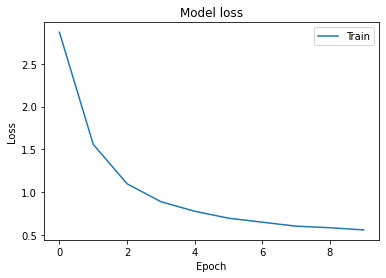

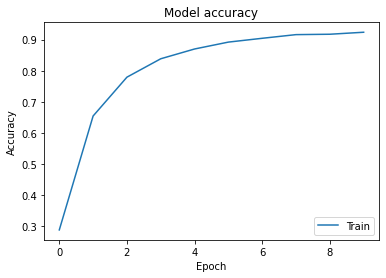

In [ ]:
# Plot training & validation loss values
plt.plot(history_prot_model_cross_val.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history_prot_model_cross_val.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


In [ ]:
#make predictions on eval dataset :
val_loss, val_acc = model_prot_cnn_cross_val.evaluate(eval_ohe, y_eval)
print(val_loss,val_acc)


# make predictions
y_pred_proba = model_prot_cnn_cross_val.predict(test_ohe)

# Write predictions to a file
with open(path_to_data + 'history_prot_model_cross_val.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(18):
        lst.append('class'+str(i))
    lst.insert(0, "name")
    writer.writerow(lst)
    for i, protein in enumerate(proteins_test):
        lst = y_pred_proba[i,:].tolist()
        lst.insert(0, protein)
        writer.writerow(lst)

NameError: ignored

### Without cross-validation

In [ ]:

# model
x_input = Input(shape=(100, 21))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)
#res3 = residual_block(res2, 16, 4)
#res4 = residual_block(res3, 16, 5)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(18, activation='softmax', kernel_regularizer=l2(0.001))(x)

model_prot_cnn = Model(inputs=x_input, outputs=x_output)

class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(df_train['location']), y= df_train['location'].values)
class_weights = dict(enumerate(class_weights))

model_prot_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_prot_cnn.summary()
'''

# Early Stopping
#es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
'''
history_prot_model = model_prot_cnn.fit(
    train_ohe, y_train,
    class_weight = class_weights,
    epochs=20, batch_size=128,
    validation_data=(eval_ohe, y_eval)
   # callbacks=[es]
    )

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100, 21)]    0           []                               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 100, 128)     2816        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 100, 128)    512         ['conv1d_11[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 100, 128)     0           ['batch_normalization_8[0][

39/39 [==============================] - 1s 24ms/step


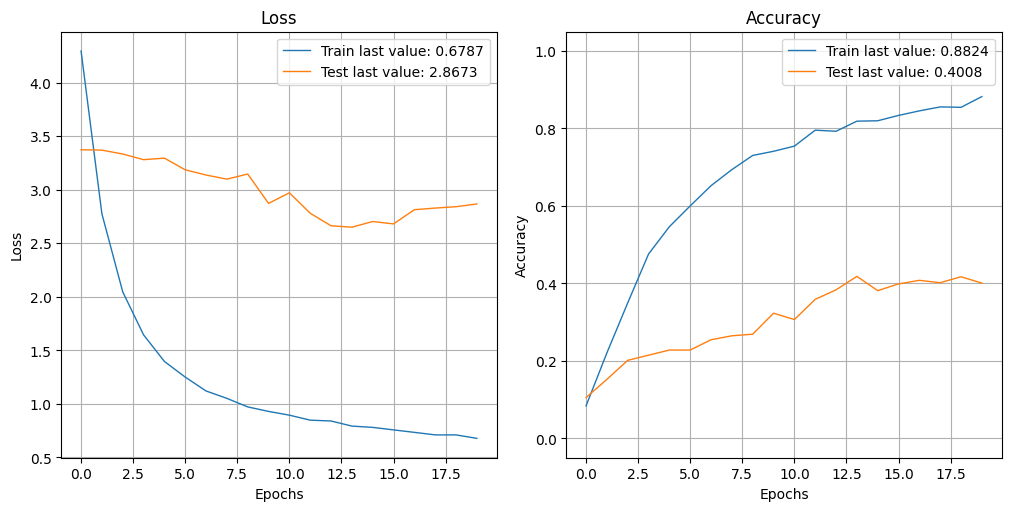

In [ ]:
# saving model weights.
model_prot_cnn.save_weights(path_to_data + 'model_prot_cnn.h5')

plot_history(history_prot_model)

# Train a logistic regression classifier and use the classifier to
# make predictions
y_pred_proba = model_prot_cnn.predict(test_ohe)
# Write predictions to a file
with open(path_to_data + 'model_prot_cnn.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(18):
        lst.append('class'+str(i))
    lst.insert(0, "name")
    writer.writerow(lst)
    for i, protein in enumerate(proteins_test):
        lst = y_pred_proba[i,:].tolist()
        lst.insert(0, protein)
        writer.writerow(lst)

## Bi-Directional Long Short Term Memory (BiLSTM)

### With cross-validation

In [11]:
# Define the number of folds
num_folds = 5

# Define the KFold object
kf = KFold(n_splits=num_folds)

# Initialize a list to store the validation scores
val_scores = []

# Loop through the folds
for train_index, val_index in kf.split(train_eval_pad):
    # Split the data into training and validation sets
    x_train, x_val = train_eval_pad[train_index], train_eval_pad[val_index]
    y_train, y_val = y_train_eval[train_index], y_train_eval[val_index]
    
    # Create a new model for each fold
    x_input = Input(shape=(100,))
    emb = Embedding(21, 64, input_length=max_length)(x_input)
    bi_rnn = Bidirectional(LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(emb)
    x = Dropout(0.3)(bi_rnn)

    # softmax classifier
    x_output = Dense(18, activation='softmax')(x)

    model_bi_directional_LSTM = Model(inputs=x_input, outputs=x_output)
    
    class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(df_train_eval['location']), y= df_train_eval['location'].values)
    class_weights = dict(enumerate(class_weights))

    model_bi_directional_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Early Stopping
    es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
    
    history_bidirect_LSTM = model_bi_directional_LSTM.fit(
        x_train, y_train,
        class_weight = class_weights,
        epochs=50, batch_size=32,
        validation_data=(x_val, y_val),
        callbacks=[es])
    
    # Evaluate the model on the validation set
    val_score = model_bi_directional_LSTM.evaluate(x_val, y_val, verbose=0)
    
    # Append the validation score to the list
    val_scores.append(val_score)

# Print the mean and standard deviation of the validation scores
print("Validation score: {:.4f} (+/- {:.4f})".format(np.mean(val_scores), np.std(val_scores)))


Epoch 1/50
123/123 [==============================] - 6s 18ms/step - loss: 4.5418 - accuracy: 0.0678 - val_loss: 3.6366 - val_accuracy: 0.0470
Epoch 2/50
123/123 [==============================] - 1s 11ms/step - loss: 3.5366 - accuracy: 0.0783 - val_loss: 3.3292 - val_accuracy: 0.0419
Epoch 3/50
123/123 [==============================] - 1s 11ms/step - loss: 3.3531 - accuracy: 0.0852 - val_loss: 3.2304 - val_accuracy: 0.0072
Epoch 4/50
123/123 [==============================] - 1s 11ms/step - loss: 3.2495 - accuracy: 0.0609 - val_loss: 3.1595 - val_accuracy: 0.0378
Epoch 5/50
123/123 [==============================] - 1s 11ms/step - loss: 3.1725 - accuracy: 0.0673 - val_loss: 3.1131 - val_accuracy: 0.0143
Epoch 6/50
123/123 [==============================] - 1s 11ms/step - loss: 3.1084 - accuracy: 0.0847 - val_loss: 3.0873 - val_accuracy: 0.0256
Epoch 7/50
123/123 [==============================] - 1s 12ms/step - loss: 3.0618 - accuracy: 0.0575 - val_loss: 3.0487 - val_accuracy: 0.0389

###Without cross-validation 

In [ ]:
x_input = Input(shape=(100,))
emb = Embedding(21, 256, input_length=100)(x_input)
bi_rnn = Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(emb)
x = Dropout(0.3)(bi_rnn)

# softmax classifier
x_output = Dense(18, activation='softmax')(x)

model_bi_directional_LSTM = Model(inputs=x_input, outputs=x_output)

class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(df_train['location']), y= df_train['location'].values)
class_weights = dict(enumerate(class_weights))

model_bi_directional_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_bi_directional_LSTM.summary()


# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history_bidirect_LSTM = model_bi_directional_LSTM.fit(
    train_pad, y_train,
    class_weight = class_weights,
    epochs=15, batch_size=128,
    validation_data=(eval_pad, y_eval),
    callbacks=[es])



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 256)          5376      
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 18)                2322      
                                                                 
Total params: 172,050
Trainable params: 172,050
Non-trainable params: 0
_____________________________________________________

NameError: ignored

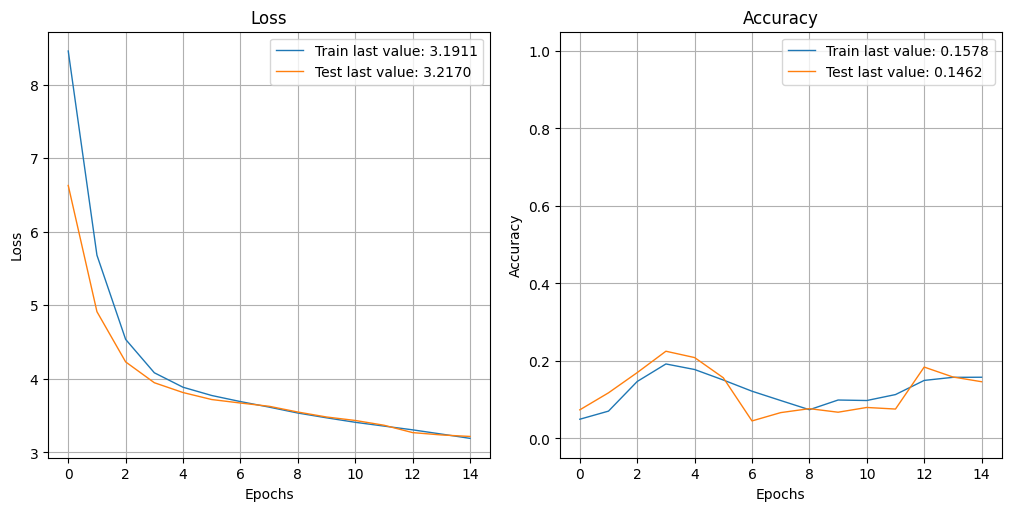

In [ ]:
plot_history(history_bidirect_LSTM)

#make predictions on eval dataset :
val_loss, val_acc = model_prot_cnn_cross_val.evaluate(eval_ohe, y_eval)
print(val_loss,val_acc)

In [ ]:
# Train a logistic regression classifier and use the classifier to
# make predictions
y_pred_proba_1 = model_bi_directional_LSTM.predict(test_pad)

# Write predictions to a file
with open(path_to_data + 'model_BiDirectionalLSTM.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(18):
        lst.append('class'+str(i))
    lst.insert(0, "name")
    writer.writerow(lst)
    for i, protein in enumerate(proteins_test):
        lst = y_pred_proba_1[i,:].tolist()
        lst.insert(0, protein)
        writer.writerow(lst)

39/39 [==============================] - 58s 5ms/step
